# Methodology for Calculating Minimum Insurance Fund

### TL;DR

This methodology outlines how to calculate the necessary insurance fund to cover potential losses from significant funding rate drawdowns, using historical funding rate data and current collateral values. Key steps include data loading and preparation, drawdown detection via moving averages, and insurance calculation based on current asset values across different exchanges. The process ensures that the insurance fund is robust enough to handle adverse market conditions by analyzing both historical trends and current market data.

### Methodology

This document provides a detailed methodology for determining the minimum insurance fund needed to mitigate potential losses from significant drawdowns in asset funding rates. The approach uses historical funding rate data from CSV files (`BTC_merged.csv` and `ETH_merged.csv`), containing daily rates from exchanges like Binance, Bybit, Deribit, and OKX. Additionally, current collateral data is sourced from an API (`https://app.ethena.fi/api/positions/current/collateral`), providing real-time USD values of assets across these exchanges.

The process begins with loading the historical funding data into pandas DataFrames, with date parsing and NaN handling to maintain data integrity. Drawdowns are identified using a moving average to smooth out the data, set by a `window_size` parameter to average over specified days, enhancing trend visibility and reducing noise. This smoothed data helps in detecting significant falls by defining a fall as a period of substantial negative changes, aggregating closely occurring falls based on an `ignore_window`.

Refer to the Funding Rate Impact Notebooks for [BTC](funding_rate_impact_btc.ipynb) and [ETH](funding_rate_impact_eth.ipynb) for detailed steps on identification of these drawdowns and the impact of the funding rates on the insurance fund.

Post drawdown identification, the analysis moves to calculating the insurance requirements. We first load drawdown impacts from `BTC_impact.csv` and `ETH_impact.csv`, merging them into a unified frame and converting it into a dictionary for manipulation. The current collateral data is fetched and parsed, grouping similar assets (e.g., stETH, mETH, LsETH, WBETH under 'LST') and aggregating their USD values per exchange.

The calculation involves filtering for relevant assets (ETH, BTC), creating a dictionary for USD amounts by (exchange, asset) pairs, updating the drawdown DataFrame with these values, and calculating maximum and overall drawdowns and buffer values in USD for each pair. The sum of these values provides the total insurance required.

Results are formatted to include total drawdown, net change in reserve fund position, buffer values, average drawdown duration, assumed daily rate for LST, and LST return based on the average duration and rate. This structured approach ensures the insurance fund is well-equipped to handle adverse market conditions by leveraging historical and current data insights.



In [1]:
from requests import get, post
from web3 import Web3, HTTPProvider
from icecream import ic
import numpy as np
import pandas as pd
import sys
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:
# Read the CSV files
BTC_impact = pd.read_csv("BTC_impact.csv")
ETH_impact = pd.read_csv("ETH_impact.csv")

# Concat the dataframes
drawdown_df = pd.concat([BTC_impact, ETH_impact], ignore_index=True)

# Convert the dataframe to a dictionary
drawdown_dict = drawdown_df.to_dict(orient='list')
print(json.dumps(drawdown_dict, indent=4))

{
    "exchange": [
        "Binance",
        "Bybit",
        "Deribit",
        "Okx",
        "Binance",
        "Bybit",
        "Deribit",
        "Okx"
    ],
    "max_drawdown_percent": [
        -1.645862,
        -1.8430561428571424,
        -1.863220372945925,
        -1.1063252387021558,
        -1.8887254285714268,
        -2.186914714285713,
        -5.816507004736813,
        -5.186162776852381
    ],
    "overall_percent": [
        -1.3575790000000003,
        -1.5053710000000002,
        -1.8553605798089237,
        -0.0778997687234245,
        -1.550566000000031,
        -1.6478019999999982,
        -5.642441661836988,
        -3.584446204511889
    ],
    "drawdown_start": [
        "2020-03-10",
        "2020-03-29",
        "2022-11-06",
        "2022-03-18",
        "2022-08-06",
        "2022-08-18",
        "2022-06-07",
        "2022-05-08"
    ],
    "drawdown_end": [
        "2020-04-26",
        "2020-04-26",
        "2023-01-09",
        "2022-07-18",
    

In [3]:
# Convert drawdown_dict to a DataFrame
drawdown_df = pd.DataFrame(drawdown_dict)

In [4]:
drawdown_df

,exchange,max_drawdown_percent,overall_percent,drawdown_start,drawdown_end,buffer,asset
0,Binance,-1.645862,-1.357579,2020-03-10,2020-04-26,0.288283,BTC
1,Bybit,-1.843056,-1.505371,2020-03-29,2020-04-26,0.337685,BTC
2,Deribit,-1.863220,-1.855361,2022-11-06,2023-01-09,0.007860,BTC
3,Okx,-1.106325,-0.077900,2022-03-18,2022-07-18,1.028425,BTC
4,Binance,-1.888725,-1.550566,2022-08-06,2022-10-08,0.338159,ETH
5,Bybit,-2.186915,-1.647802,2022-08-18,2022-11-18,0.539113,ETH
6,Deribit,-5.816507,-5.642442,2022-06-07,2022-12-02,0.174065,ETH
7,Okx,-5.186163,-3.584446,2022-05-08,2022-12-28,1.601717,ETH


In [5]:

url_collateral = "https://app.ethena.fi/api/positions/current/collateral"
response_collateral = get(url_collateral)
data_collateral = response_collateral.json()

collateral_data = data_collateral.get('collateral', [])

In [6]:
from collections import defaultdict

# Define the assets to be grouped under LST
group_assets = ['stETH', 'mETH', 'LsETH', 'WBETH']

# Initialize a dictionary to accumulate the USD amounts for the grouped asset by exchange
grouped_data = defaultdict(lambda: {'usdAmount': 0, 'timestamp': 0})

# Iterate through the collateral data and accumulate the amounts for the grouped asset
for entry in collateral_data:
    if entry['asset'] in group_assets:
        exchange = entry['exchange']
        grouped_data[exchange]['usdAmount'] += entry['usdAmount']
        grouped_data[exchange]['timestamp'] = max(grouped_data[exchange]['timestamp'], entry['timestamp'])

# Create new entries for the grouped asset
for exchange, data in grouped_data.items():
    new_entry = {
        'asset': 'ETH',
        'exchange': exchange,
        'timestamp': data['timestamp'],
        'usdAmount': data['usdAmount']
    }
    collateral_data.append(new_entry)

# Create new entries for the grouped asset
for exchange, data in grouped_data.items():
    new_entry = {
        'asset': 'LST',
        'exchange': exchange,
        'timestamp': data['timestamp'],
        'usdAmount': data['usdAmount']
    }
    collateral_data.append(new_entry)
    
# Output the modified collateral_data to verify the results
collateral_data


[{'asset': 'stETH',
  'exchange': 'Binance',
  'timestamp': 1730120389,
  'usdAmount': 0},
 {'asset': 'stETH',
  'exchange': 'Bybit',
  'timestamp': 1730120389,
  'usdAmount': 41134363},
 {'asset': 'stETH',
  'exchange': 'Bitget',
  'timestamp': 1730120389,
  'usdAmount': 16770821},
 {'asset': 'stETH',
  'exchange': 'Deribit',
  'timestamp': 1730120389,
  'usdAmount': 0},
 {'asset': 'stETH',
  'exchange': 'Okx',
  'timestamp': 1730120389,
  'usdAmount': 0},
 {'asset': 'stETH',
  'exchange': 'Unallocated',
  'timestamp': 1730120389,
  'usdAmount': 829653},
 {'asset': 'WBETH',
  'exchange': 'Binance',
  'timestamp': 1730120389,
  'usdAmount': 169070539},
 {'asset': 'WBETH',
  'exchange': 'Bybit',
  'timestamp': 1730120389,
  'usdAmount': 0},
 {'asset': 'WBETH',
  'exchange': 'Bitget',
  'timestamp': 1730120389,
  'usdAmount': 0},
 {'asset': 'WBETH',
  'exchange': 'Deribit',
  'timestamp': 1730120389,
  'usdAmount': 0},
 {'asset': 'WBETH',
  'exchange': 'Okx',
  'timestamp': 1730120389,
 

In [7]:
total_lst_usd_amount = sum(entry['usdAmount'] for entry in collateral_data if entry['asset'] == 'LST')
print(f"Total USD Amount of LST: $ {total_lst_usd_amount:,.2f}")


# Define a function to calculate the duration between start and end dates
def calculate_durations(drawdown_dict):
    durations = []
    for start, end in zip(drawdown_dict['drawdown_start'], drawdown_dict['drawdown_end']):
        start_date = datetime.strptime(start, "%Y-%m-%d")
        end_date = datetime.strptime(end, "%Y-%m-%d")
        duration = end_date - start_date
        durations.append(duration.days)
    return durations

# Calculate the durations
durations = calculate_durations(drawdown_dict)

# Calculate the average duration
average_duration = sum(durations) / len(durations)
print(f"Average Drawdown Duration: {average_duration:.2f} days")

LST_daily_rate = 0.03 # 3% daily rate
print(f"Assumed LST Daily Rate: {LST_daily_rate:.2%}")

LST_return = average_duration * LST_daily_rate * total_lst_usd_amount / 365
print(f"LST Return: ${LST_return:,.2f}")

Total USD Amount of LST: $ 286,859,350.00
Average Drawdown Duration: 103.50 days
Assumed LST Daily Rate: 3.00%
LST Return: $2,440,269.27


In [8]:

# Filter the collateral data to include only ETH and BTC assets
filtered_data = [
    entry for entry in collateral_data
    if entry['asset'] in ['ETH', 'BTC']
]

# Create a dictionary to accumulate usdAmount for (exchange, asset) pairs
usd_amount_mapping = {}
for entry in filtered_data:
    key = (entry['exchange'], entry['asset'])
    if key in usd_amount_mapping:
        usd_amount_mapping[key] += entry['usdAmount']
    else:
        usd_amount_mapping[key] = entry['usdAmount']

# Initialize the usdAmount column with default value
drawdown_df['usdAmount'] = 0

# Update the usdAmount column with relevant values from the mapping
for i, row in drawdown_df.iterrows():
    key = (row['exchange'], row['asset'])
    if key in usd_amount_mapping:
        drawdown_df.at[i, 'usdAmount'] = usd_amount_mapping[key]

# Display the updated DataFrame
drawdown_df.head(8)

,exchange,max_drawdown_percent,overall_percent,drawdown_start,drawdown_end,buffer,asset,usdAmount
0,Binance,-1.645862,-1.357579,2020-03-10,2020-04-26,0.288283,BTC,995532591
1,Bybit,-1.843056,-1.505371,2020-03-29,2020-04-26,0.337685,BTC,146866137
2,Deribit,-1.863220,-1.855361,2022-11-06,2023-01-09,0.007860,BTC,48880969
3,Okx,-1.106325,-0.077900,2022-03-18,2022-07-18,1.028425,BTC,167771612
4,Binance,-1.888725,-1.550566,2022-08-06,2022-10-08,0.338159,ETH,505445181
5,Bybit,-2.186915,-1.647802,2022-08-18,2022-11-18,0.539113,ETH,132356383
6,Deribit,-5.816507,-5.642442,2022-06-07,2022-12-02,0.174065,ETH,62323648
7,Okx,-5.186163,-3.584446,2022-05-08,2022-12-28,1.601717,ETH,125944156


In [9]:
drawdown_df['max_drawdown'] = drawdown_df['max_drawdown_percent'] * drawdown_df['usdAmount'] / 100
drawdown_df['overall_drawdown'] = drawdown_df['overall_percent'] * drawdown_df['usdAmount'] / 100
drawdown_df['buffer_usd'] = drawdown_df['buffer'] * drawdown_df['usdAmount'] / 100

# Display the updated DataFrame
drawdown_df.head(8)

,exchange,max_drawdown_percent,overall_percent,drawdown_start,drawdown_end,buffer,asset,usdAmount,max_drawdown,overall_drawdown,buffer_usd
0,Binance,-1.645862,-1.357579,2020-03-10,2020-04-26,0.288283,BTC,995532591,-1.638509e+07,-1.351514e+07,2.869951e+06
1,Bybit,-1.843056,-1.505371,2020-03-29,2020-04-26,0.337685,BTC,146866137,-2.706825e+06,-2.210880e+06,4.959451e+05
2,Deribit,-1.863220,-1.855361,2022-11-06,2023-01-09,0.007860,BTC,48880969,-9.107602e+05,-9.069182e+05,3.841943e+03
3,Okx,-1.106325,-0.077900,2022-03-18,2022-07-18,1.028425,BTC,167771612,-1.856100e+06,-1.306937e+05,1.725406e+06
4,Binance,-1.888725,-1.550566,2022-08-06,2022-10-08,0.338159,ETH,505445181,-9.546472e+06,-7.837261e+06,1.709211e+06
5,Bybit,-2.186915,-1.647802,2022-08-18,2022-11-18,0.539113,ETH,132356383,-2.894521e+06,-2.180971e+06,7.135501e+05
6,Deribit,-5.816507,-5.642442,2022-06-07,2022-12-02,0.174065,ETH,62323648,-3.625059e+06,-3.516575e+06,1.084839e+05
7,Okx,-5.186163,-3.584446,2022-05-08,2022-12-28,1.601717,ETH,125944156,-6.531669e+06,-4.514401e+06,2.017268e+06


In [10]:
# Sum the max_drawdown column data
sum_max_drawdown =float(drawdown_df['max_drawdown'].sum())
print(f"Total drawdown only considering the -ve rates for the max drawdown phase: ${sum_max_drawdown:,.2f}")

sum_overall_drawdown =float(drawdown_df['overall_drawdown'].sum())
print(f"Net change in reserve fund position due to the funding rates for the max drawdown phase: ${sum_overall_drawdown:,.2f}")

sum_buffer =float(drawdown_df['buffer_usd'].sum())
print(f"Difference/Buffer: ${sum_buffer:,.2f}")


print(f"Average Drawdown Duration: {average_duration:.2f} days")

LST_daily_rate = 0.03 # 3% daily rate
print(f"Assumed LST Daily Rate: {LST_daily_rate:.2%}")

LST_return = average_duration * LST_daily_rate * total_lst_usd_amount / 365
print(f"LST Return: ${LST_return:,.2f}")

Total drawdown only considering the -ve rates for the max drawdown phase: $-44,456,499.00
Net change in reserve fund position due to the funding rates for the max drawdown phase: $-34,812,841.81
Difference/Buffer: $9,643,657.19
Average Drawdown Duration: 103.50 days
Assumed LST Daily Rate: 3.00%
LST Return: $2,440,269.27


ic| reserve_size: -44456498.99825437
ic| position_size: 2185120677.0


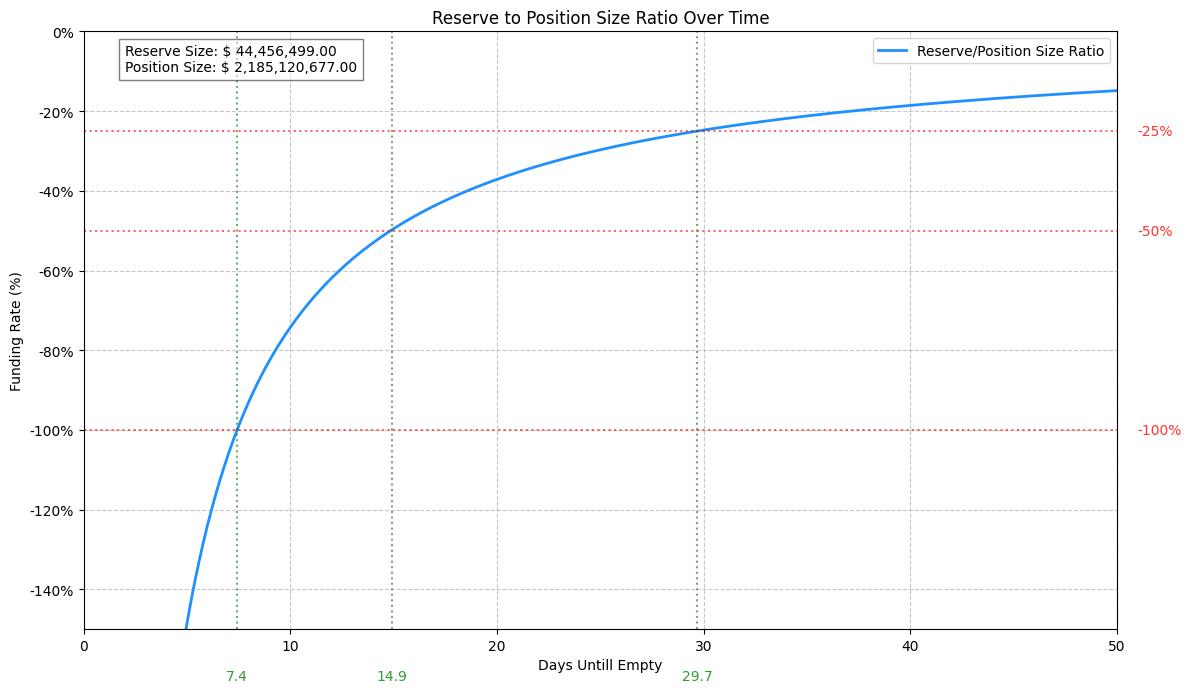

In [11]:
reserve_size = float(drawdown_df['max_drawdown'].sum()) 
ic(reserve_size)

position_size = float(drawdown_df['usdAmount'].sum())  
ic(position_size)


# Define the function y
def y(x, reserve_size, position_size):
    return (365 * reserve_size) / (position_size * x)

# Generate x and y values
x_values = np.linspace(0.1, 50, 500)  # x values from 0.1 to 50 with 500 points
y_values = y(x_values, reserve_size, position_size) * 100  # Convert to percentage

# Plot the curve
plt.figure(figsize=(12, 7))
plt.plot(x_values, y_values, label='Reserve/Position Size Ratio', color='#1e90ff', linewidth=2)

# Labels and title
plt.xlabel('Days Untill Empty')
plt.ylabel('Funding Rate (%)')
plt.title('Reserve to Position Size Ratio Over Time')

# Set x and y axis limits
plt.xlim(0, 50)
plt.ylim(-150, 0)

# Format y axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0f}%"))

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Add horizontal lines for key percentages
key_percentages = [-100, -50, -25]
for percentage in key_percentages:
    plt.axhline(y=percentage, color='red', linestyle=':', alpha=0.6)
    plt.text(51, percentage, f'{percentage}%', va='center', ha='left', color='red', alpha=0.8)

# Find and plot vertical lines at the x values where the curve intersects key percentages
for percentage in key_percentages:
    # Find the closest point to the target percentage
    idx = np.argmin(np.abs(y_values - percentage))
    x_intersection = x_values[idx]
    
    # Plot the vertical line
    plt.axvline(x=x_intersection, color='green', linestyle=':', alpha=0.6)
    plt.text(x_intersection, -160, f'{x_intersection:.1f}', va='top', ha='center', color='green', alpha=0.8, fontsize=10)

# Annotate reserve_size and position_size on the chart
text_str = f"Reserve Size: $ {-reserve_size:,.2f}\nPosition Size: $ {position_size:,.2f}"
plt.text(2, -10, text_str, color='black', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [12]:
# URL to fetch the data
url_funds = "https://app.ethena.fi/api/solvency/reserve-fund"

# Sending a GET request to the URL
response_funds = get(url_funds)

# Parsing the JSON response
data_funds = response_funds.json()

# Extracting the 'queryIndex' list from the response
reserve_funds = data_funds.get('queryIndex', [])

# Extracting the yield values from the 'queryIndex' list
yields = reserve_funds[0].get('yields', [])

# Finding the yield entry with the highest timestamp
latest_yield = max(yields, key=lambda x: x['timestamp'])

# Extracting the value of the latest yield entry
actual_reserve_size = latest_yield['value']


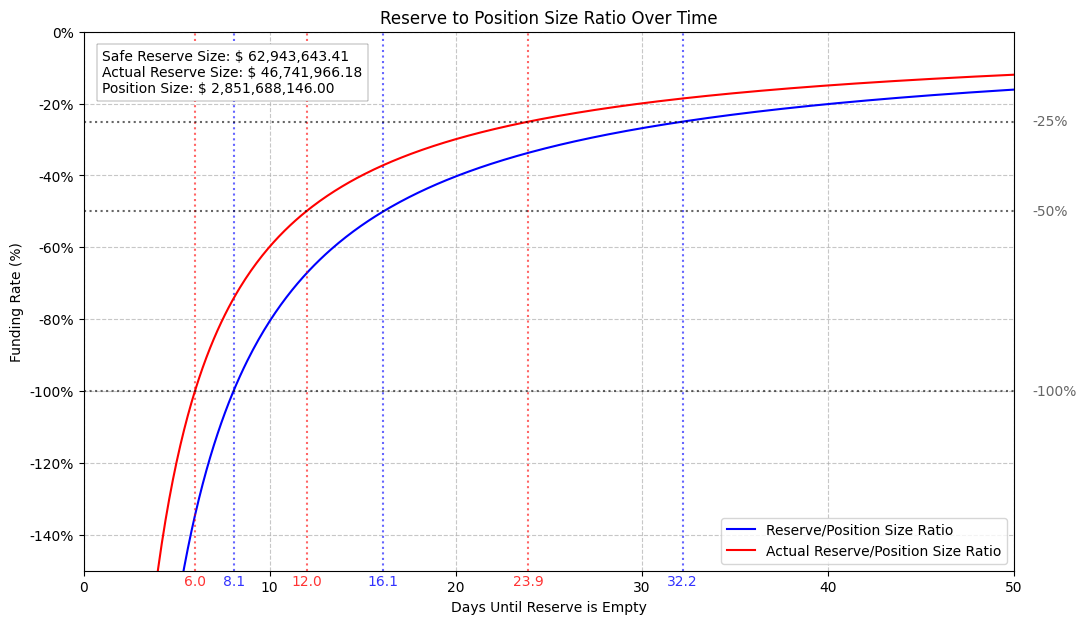

In [13]:
def y(x, size, position_size):
    return (365 * size) / (position_size * x)

def plot_curve_with_intersections(size, label, color, linestyle='-'):
    y_values = y(x_values, size, position_size) * 100  # Convert to percentage
    plt.plot(x_values, y_values, label=label, color=color, linewidth=1.5, linestyle=linestyle)
    
    # Find and plot vertical lines at the x values where the curve intersects key percentages
    for percentage in key_percentages:
        # Find the closest point to the target percentage
        idx = np.argmin(np.abs(y_values - percentage))
        x_intersection = x_values[idx]
        
        # Plot the vertical line
        plt.axvline(x=x_intersection, color=color, linestyle=':', alpha=0.6)
        plt.text(x_intersection, -155, f'{x_intersection:.1f}', va='bottom', ha='center', 
                 color=color, alpha=0.8)

def create_reserve_position_ratio_chart(actual_reserve_size, reserve_size, position_size):
    global x_values, key_percentages
    
    # Generate x values
    x_values = np.linspace(0.1, 50, 500)  # x values from 0.1 to 50 with 500 points
    
    # Define key percentages
    key_percentages = [-100, -50, -25]

    # Plotting
    plt.figure(figsize=(12, 7))
    plot_curve_with_intersections(reserve_size, 'Reserve/Position Size Ratio', 'blue')
    plot_curve_with_intersections(actual_reserve_size, 'Actual Reserve/Position Size Ratio', 'red')

    # Labels and title
    plt.xlabel('Days Until Reserve is Empty')
    plt.ylabel('Funding Rate (%)')
    plt.title('Reserve to Position Size Ratio Over Time')

    # Set x and y axis limits
    plt.xlim(0, 50)
    plt.ylim(-150, 0)

    # Format y axis as percentage
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0f}%"))

    # Grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    # Add horizontal lines for key percentages
    for percentage in key_percentages:
        plt.axhline(y=percentage, color='black', linestyle=':', alpha=0.6)
        plt.text(51, percentage, f'{percentage}%', va='center', ha='left', color='black', alpha=0.6)

    # Annotate reserve_size, actual_reserve_size, and position_size on the chart
    text_str = f"Safe Reserve Size: $ {-reserve_size:,.2f}\nActual Reserve Size: $ {-actual_reserve_size:,.2f}\nPosition Size: $ {position_size:,.2f}"
    plt.text(1, -17, text_str, color='black', bbox=dict(facecolor='white',linewidth=0.2))

    plt.show()

# Example usage:
actual_reserve_size =  latest_yield['value'] * -1

reserve_size = -62943643.41  # This is the calculated reserve size
position_size = 2851688146.00

create_reserve_position_ratio_chart(actual_reserve_size, reserve_size, position_size)